# Diffusion Transformer (DiT)

In the previous notebook, we built a flow matching model using a **CNN (U-Net)**. It worked - we generated digits from noise! But the architecture has fundamental limitations.

In this notebook, we replace the CNN with a **Diffusion Transformer (DiT)** - the same architecture behind Stable Diffusion 3, Sora, and other state-of-the-art generators.

## The Limitations of CNNs

CNNs process images through local convolution kernels (typically 3×3 or 5×5):

```
CNN Receptive Field Growth:

Layer 1: Each pixel sees 3×3 = 9 pixels
Layer 2: Each pixel sees 5×5 = 25 pixels  
Layer 3: Each pixel sees 7×7 = 49 pixels
  ...
Layer N: Receptive field grows linearly with depth
```

**Problem**: To see the whole 28×28 image, you need many layers. Information must propagate step-by-step through the network.

## Why Transformers?

| Aspect | CNN (U-Net) | Transformer (DiT) |
|--------|-------------|-------------------|
| **Receptive Field** | Local (3×3), grows with depth | Global from layer 1 |
| **Long-range Dependencies** | Requires many layers | Direct attention |
| **Scaling Laws** | Diminishing returns | Predictable improvement |
| **Conditioning** | Add/concatenate features | Modulate every operation (adaLN) |

The key insight from the [DiT paper](https://arxiv.org/abs/2212.09748): transformers follow **scaling laws**. Double the compute → predictably better results. This is why modern image generators use transformers.

## What We'll Learn

1. **Patchification**: Converting images to sequences (the bridge to transformers)
2. **Positional Embeddings**: Encoding 2D spatial structure
3. **Self-Attention**: The mathematical heart of transformers
4. **Adaptive Layer Norm (adaLN)**: Superior timestep conditioning

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2

# Set up device
from from_noise_to_images import get_device
device = get_device()
print(f"Using device: {device}")

Using device: cuda


## 1. Patchification: Images as Token Sequences

Transformers were designed for **sequences** of tokens (words in NLP). To apply them to images, we need to convert the 2D pixel grid into a 1D sequence.

### The Mathematical Operation

For an image $x \in \mathbb{R}^{H \times W \times C}$ with patch size $P$:

1. **Divide into patches**: Split into $N = \frac{H}{P} \times \frac{W}{P}$ non-overlapping patches
2. **Flatten each patch**: Each patch becomes a vector of dimension $P^2 \cdot C$
3. **Project to embedding space**: Linear projection $E \in \mathbb{R}^{(P^2 \cdot C) \times D}$

$$\text{patches} = \text{Reshape}(x) \cdot E \in \mathbb{R}^{N \times D}$$

For our MNIST images (28×28×1) with patch size 4:
- $N = \frac{28}{4} \times \frac{28}{4} = 7 \times 7 = 49$ patches
- Each patch: $4 \times 4 \times 1 = 16$ pixels
- Projected to $D = 256$ dimensions

### Why Patches Work

| Approach | Sequence Length | Computation |
|----------|-----------------|-------------|
| Pixel-level | $28 \times 28 = 784$ tokens | $O(784^2) = 614,656$ |
| Patch-level (P=4) | $7 \times 7 = 49$ tokens | $O(49^2) = 2,401$ |

Patches reduce computation by **256×** while preserving local structure within each patch.

### The Trade-off

- **Larger patches**: Fewer tokens, faster, but lose fine detail
- **Smaller patches**: More tokens, slower, but preserve detail
- **Common choices**: P=8, 14, or 16 for 224×224 images; P=4 for our 28×28 images

In [2]:
# Load MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

sample_img, label = train_dataset[0]
print(f"Image shape: {sample_img.shape}")
print(f"Label: {label}")

Image shape: torch.Size([1, 28, 28])
Label: 5


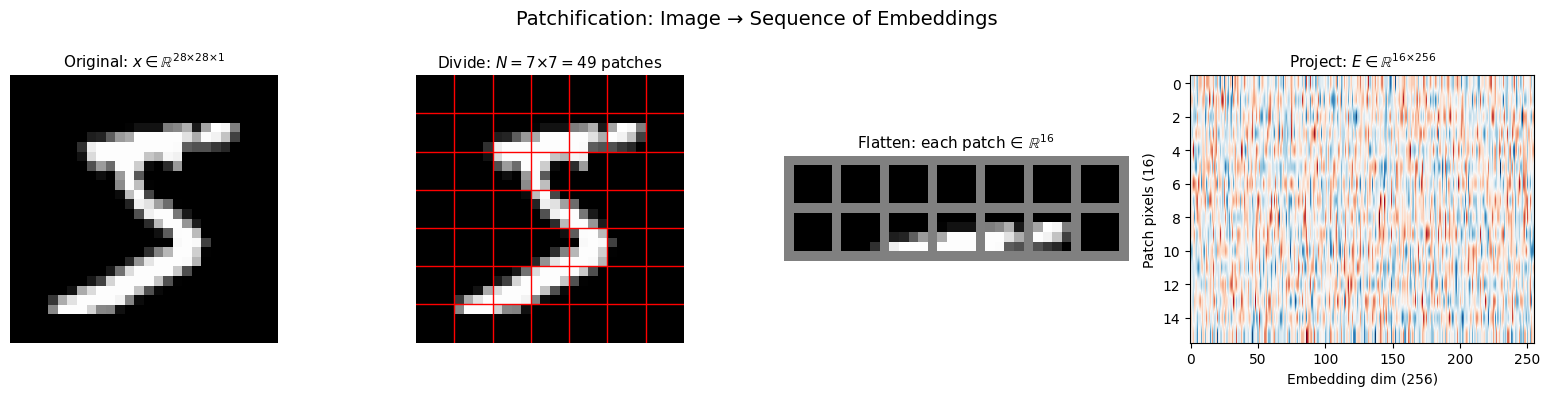


📊 Patchification Summary:
   Input:  x ∈ ℝ^(28×28×1) = 784 values
   Patches: 49 patches, each 4×4 = 16 pixels
   Output: 49 tokens, each 256-dimensional
   Computation reduction: 784² → 49² = 614,656 → 2,401 (256× fewer)


In [3]:
def visualize_patchification(img, patch_size=4):
    """
    Visualize the patchification process with mathematical annotations.
    """
    img_display = (img[0] + 1) / 2  # Denormalize
    H, W = img_display.shape
    num_patches_h = H // patch_size
    num_patches_w = W // patch_size
    N = num_patches_h * num_patches_w
    
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    
    # Original image
    axes[0].imshow(img_display.numpy(), cmap='gray')
    axes[0].set_title(f'Original: $x \\in \\mathbb{{R}}^{{{H}×{W}×1}}$', fontsize=11)
    axes[0].axis('off')
    
    # Image with patch grid
    axes[1].imshow(img_display.numpy(), cmap='gray')
    for i in range(1, num_patches_h):
        axes[1].axhline(y=i * patch_size - 0.5, color='red', linewidth=1)
    for j in range(1, num_patches_w):
        axes[1].axvline(x=j * patch_size - 0.5, color='red', linewidth=1)
    axes[1].set_title(f'Divide: $N = {num_patches_h}×{num_patches_w} = {N}$ patches', fontsize=11)
    axes[1].axis('off')
    
    # Extract and show patches as sequence
    patches = img_display.unfold(0, patch_size, patch_size).unfold(1, patch_size, patch_size)
    patches = patches.reshape(-1, patch_size, patch_size)
    
    patch_grid = torchvision.utils.make_grid(
        patches[:14].unsqueeze(1), nrow=7, padding=1, pad_value=0.5
    )
    axes[2].imshow(patch_grid[0].numpy(), cmap='gray')
    axes[2].set_title(f'Flatten: each patch ∈ $\\mathbb{{R}}^{{{patch_size**2}}}$', fontsize=11)
    axes[2].axis('off')
    
    # Show embedding projection conceptually
    embed_dim = 256
    projection = np.random.randn(patch_size**2, embed_dim) * 0.1
    axes[3].imshow(projection, aspect='auto', cmap='RdBu', vmin=-0.3, vmax=0.3)
    axes[3].set_xlabel(f'Embedding dim ({embed_dim})')
    axes[3].set_ylabel(f'Patch pixels ({patch_size**2})')
    axes[3].set_title(f'Project: $E \\in \\mathbb{{R}}^{{{patch_size**2}×{embed_dim}}}$', fontsize=11)
    
    plt.suptitle('Patchification: Image → Sequence of Embeddings', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Patchification Summary:")
    print(f"   Input:  x ∈ ℝ^({H}×{W}×1) = {H*W} values")
    print(f"   Patches: {N} patches, each {patch_size}×{patch_size} = {patch_size**2} pixels")
    print(f"   Output: {N} tokens, each {embed_dim}-dimensional")
    print(f"   Computation reduction: {H*W}² → {N}² = {(H*W)**2:,} → {N**2:,} ({(H*W)**2 // N**2}× fewer)")

visualize_patchification(sample_img, patch_size=4)

## 2. Positional Embeddings: Encoding Spatial Structure

When we flatten patches into a sequence, we lose spatial information. The transformer sees:

$$[p_1, p_2, p_3, \ldots, p_{49}]$$

But it doesn't know that $p_1$ is top-left and $p_{49}$ is bottom-right!

### The Solution: Add Position Information

We add a **positional embedding** to each patch embedding:

$$z_i = p_i + \text{PE}(\text{row}_i, \text{col}_i)$$

### Sinusoidal Positional Encoding

We use sinusoidal functions at different frequencies (from "Attention Is All You Need"):

$$\text{PE}(\text{pos}, 2i) = \sin\left(\frac{\text{pos}}{10000^{2i/d}}\right)$$
$$\text{PE}(\text{pos}, 2i+1) = \cos\left(\frac{\text{pos}}{10000^{2i/d}}\right)$$

where $i$ is the dimension index and $d$ is the embedding dimension.

### Why Sinusoids?

1. **Unique encoding**: Each position gets a unique pattern
2. **Relative positions**: $\text{PE}(\text{pos}+k)$ can be expressed as a linear function of $\text{PE}(\text{pos})$
3. **Bounded values**: All values in $[-1, 1]$
4. **No learned parameters**: Works for any sequence length

### 2D Extension for Images

For images, we encode both row and column positions:

$$\text{PE}_{2D}(r, c) = [\text{PE}_{1D}(r), \text{PE}_{1D}(c)]$$

Each position gets a $D$-dimensional vector: $D/2$ dimensions for row, $D/2$ for column.

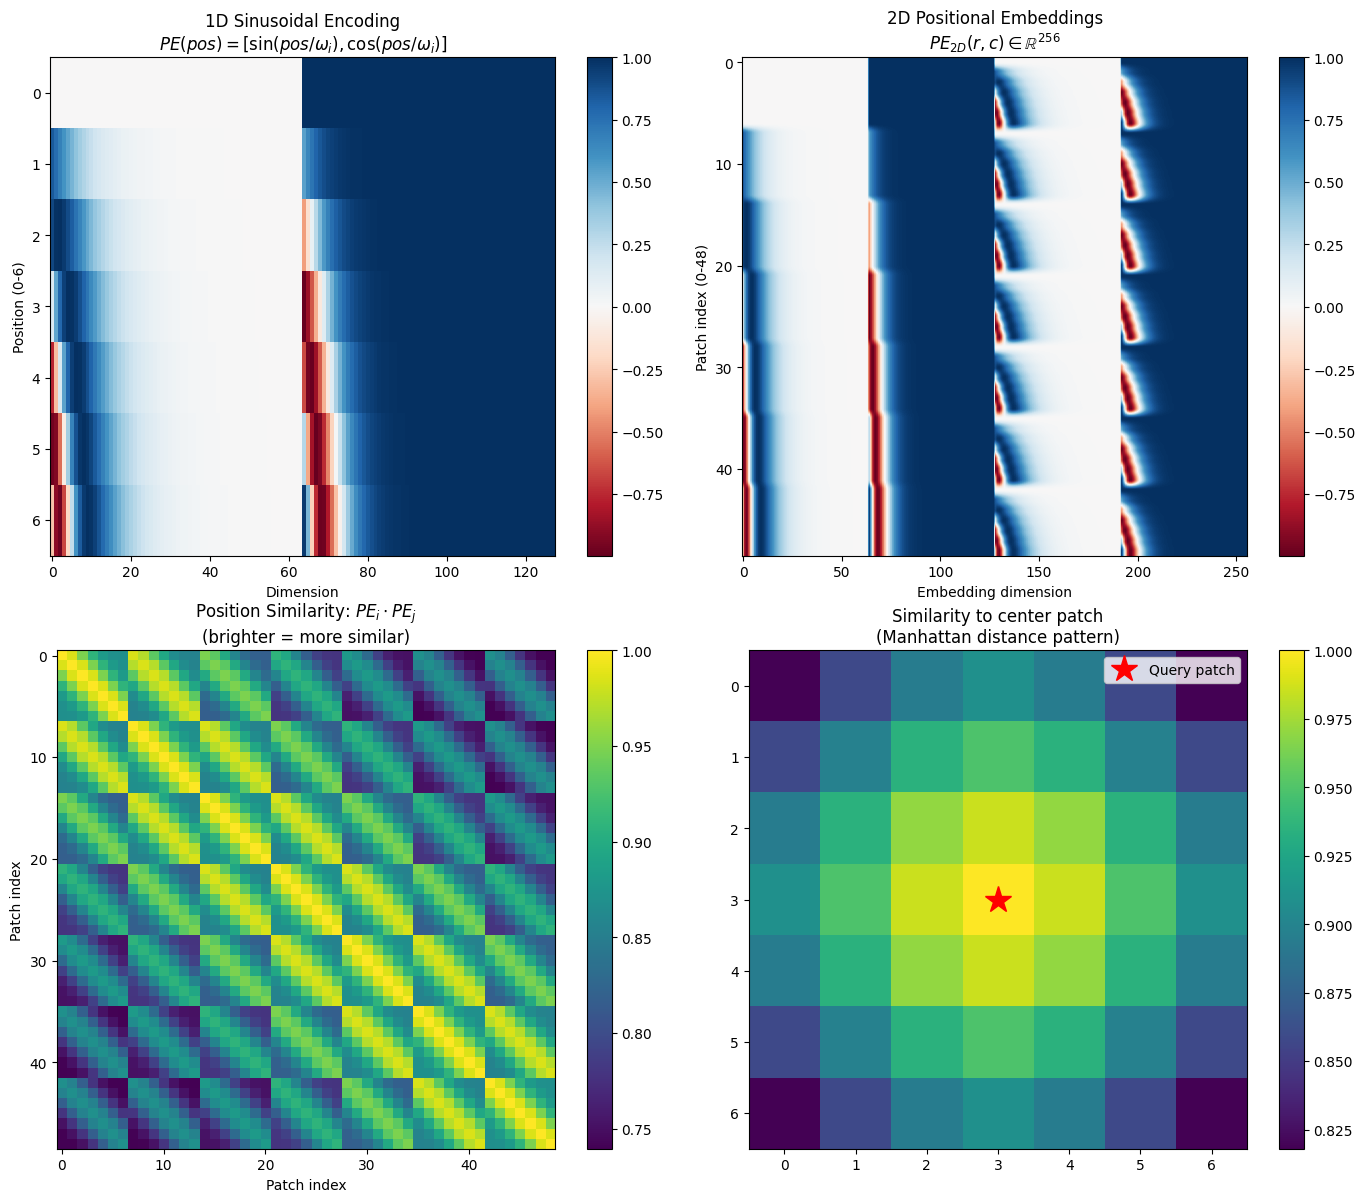


📊 Positional Embedding Properties:
   • Each position gets a unique 256D vector
   • Nearby patches have similar embeddings (high dot product)
   • Distant patches have dissimilar embeddings (low dot product)
   • The model can learn to interpret these patterns


In [4]:
def visualize_positional_embeddings(grid_size=7, embed_dim=256):
    """
    Visualize 2D sinusoidal positional embeddings with mathematical detail.
    """
    import math
    
    # Create 1D sinusoidal embeddings
    half_dim = embed_dim // 4  # sin_row, cos_row, sin_col, cos_col
    
    # Frequency bands: 10000^(-2i/d)
    freq = math.log(10000) / (half_dim - 1)
    freq = torch.exp(torch.arange(half_dim) * -freq)
    
    # Position indices
    pos = torch.arange(grid_size).float()
    
    # Compute PE: pos × freq gives the angle
    angles = pos[:, None] * freq[None, :]  # (grid_size, half_dim)
    sin_emb = torch.sin(angles)
    cos_emb = torch.cos(angles)
    pos_1d = torch.cat([sin_emb, cos_emb], dim=-1)  # (grid_size, embed_dim/2)
    
    # Create 2D embeddings
    row_emb = pos_1d.unsqueeze(1).expand(-1, grid_size, -1)
    col_emb = pos_1d.unsqueeze(0).expand(grid_size, -1, -1)
    pos_2d = torch.cat([row_emb, col_emb], dim=-1)  # (7, 7, 256)
    pos_flat = pos_2d.view(-1, embed_dim)  # (49, 256)
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    # 1D embeddings
    im = axes[0, 0].imshow(pos_1d.numpy(), aspect='auto', cmap='RdBu')
    axes[0, 0].set_xlabel('Dimension')
    axes[0, 0].set_ylabel('Position (0-6)')
    axes[0, 0].set_title('1D Sinusoidal Encoding\n$PE(pos) = [\\sin(pos/\\omega_i), \\cos(pos/\\omega_i)]$')
    plt.colorbar(im, ax=axes[0, 0])
    
    # Full 2D embedding matrix
    im = axes[0, 1].imshow(pos_flat.numpy(), aspect='auto', cmap='RdBu')
    axes[0, 1].set_xlabel('Embedding dimension')
    axes[0, 1].set_ylabel('Patch index (0-48)')
    axes[0, 1].set_title(f'2D Positional Embeddings\n$PE_{{2D}}(r,c) \\in \\mathbb{{R}}^{{{embed_dim}}}$')
    plt.colorbar(im, ax=axes[0, 1])
    
    # Dot-product similarity
    similarity = torch.mm(pos_flat, pos_flat.T)
    similarity = similarity / similarity.max()
    im = axes[1, 0].imshow(similarity.numpy(), cmap='viridis')
    axes[1, 0].set_xlabel('Patch index')
    axes[1, 0].set_ylabel('Patch index')
    axes[1, 0].set_title('Position Similarity: $PE_i \\cdot PE_j$\n(brighter = more similar)')
    plt.colorbar(im, ax=axes[1, 0])
    
    # Spatial similarity from center
    center = 24  # Center of 7×7 grid
    center_sim = similarity[center].view(grid_size, grid_size)
    im = axes[1, 1].imshow(center_sim.numpy(), cmap='viridis')
    axes[1, 1].plot(3, 3, 'r*', markersize=20, label='Query patch')
    axes[1, 1].set_title(f'Similarity to center patch\n(Manhattan distance pattern)')
    axes[1, 1].legend()
    plt.colorbar(im, ax=axes[1, 1])
    
    plt.tight_layout()
    plt.show()
    
    print("\n📊 Positional Embedding Properties:")
    print(f"   • Each position gets a unique {embed_dim}D vector")
    print(f"   • Nearby patches have similar embeddings (high dot product)")
    print(f"   • Distant patches have dissimilar embeddings (low dot product)")
    print(f"   • The model can learn to interpret these patterns")

visualize_positional_embeddings()

## 3. Self-Attention: The Heart of Transformers

Self-attention is what gives transformers their power. Unlike CNNs where each location only sees its local neighborhood, self-attention lets **every token attend to every other token** in a single operation.

### The Attention Mechanism

Given input tokens $X \in \mathbb{R}^{N \times D}$ (N tokens, D dimensions each):

1. **Compute Query, Key, Value** via learned projections:
   $$Q = XW_Q, \quad K = XW_K, \quad V = XW_V$$
   where $W_Q, W_K, W_V \in \mathbb{R}^{D \times D}$

2. **Compute attention scores** (how much should token $i$ attend to token $j$?):
   $$A = \text{softmax}\left(\frac{QK^T}{\sqrt{D}}\right) \in \mathbb{R}^{N \times N}$$

3. **Aggregate values** based on attention weights:
   $$\text{Output} = AV \in \mathbb{R}^{N \times D}$$

### Understanding Each Component

| Component | Intuition | Shape |
|-----------|-----------|-------|
| **Query (Q)** | "What am I looking for?" | $N \times D$ |
| **Key (K)** | "What do I contain?" | $N \times D$ |
| **Value (V)** | "What information do I provide?" | $N \times D$ |
| **Attention (A)** | "How much should I attend to each token?" | $N \times N$ |

### The Scaling Factor $\sqrt{D}$

Why divide by $\sqrt{D}$? Without it:
- Dot products $q_i \cdot k_j$ grow with dimension $D$
- Large values → softmax becomes nearly one-hot
- Gradients vanish, training fails

Dividing by $\sqrt{D}$ keeps the variance of dot products ≈ 1.

### Multi-Head Attention

Instead of one attention operation, we run $H$ parallel "heads":

$$\text{MultiHead}(X) = \text{Concat}(\text{head}_1, \ldots, \text{head}_H) W_O$$

where each head has dimension $D/H$. This lets the model attend to different aspects simultaneously.

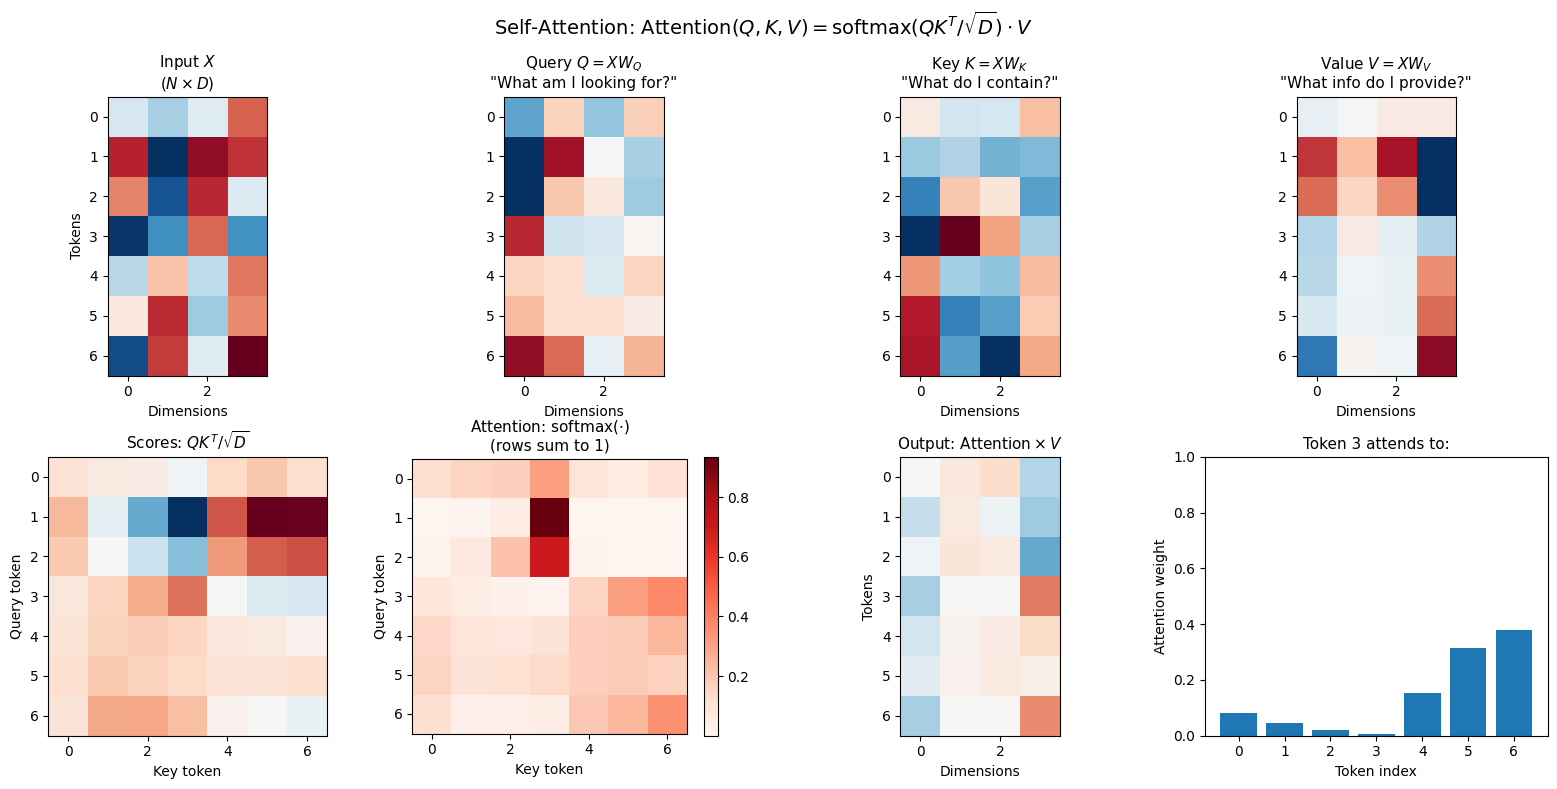


📊 Attention Properties:
   • Input: 7 tokens × 4 dimensions
   • Attention matrix: 7×7 = 49 pairwise interactions
   • Each row sums to 1 (probability distribution)
   • Computation: O(N²D) - quadratic in sequence length


In [5]:
def visualize_attention_mechanism():
    """
    Visualize the self-attention computation step by step.
    """
    N = 7  # 7 tokens (simplified for visualization)
    D = 4  # 4 dimensions
    
    # Create sample input
    np.random.seed(42)
    X = torch.randn(N, D)
    
    # Learned projections (random for illustration)
    W_Q = torch.randn(D, D) * 0.5
    W_K = torch.randn(D, D) * 0.5
    W_V = torch.randn(D, D) * 0.5
    
    # Compute Q, K, V
    Q = X @ W_Q
    K = X @ W_K
    V = X @ W_V
    
    # Compute attention scores
    scores = Q @ K.T / np.sqrt(D)
    attention = torch.softmax(scores, dim=-1)
    
    # Compute output
    output = attention @ V
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    # Row 1: The computation
    vmin, vmax = -2, 2
    
    axes[0, 0].imshow(X.numpy(), cmap='RdBu', vmin=vmin, vmax=vmax)
    axes[0, 0].set_title('Input $X$\n$(N \\times D)$', fontsize=11)
    axes[0, 0].set_xlabel('Dimensions')
    axes[0, 0].set_ylabel('Tokens')
    
    axes[0, 1].imshow(Q.numpy(), cmap='RdBu', vmin=vmin, vmax=vmax)
    axes[0, 1].set_title('Query $Q = XW_Q$\n"What am I looking for?"', fontsize=11)
    axes[0, 1].set_xlabel('Dimensions')
    
    axes[0, 2].imshow(K.numpy(), cmap='RdBu', vmin=vmin, vmax=vmax)
    axes[0, 2].set_title('Key $K = XW_K$\n"What do I contain?"', fontsize=11)
    axes[0, 2].set_xlabel('Dimensions')
    
    axes[0, 3].imshow(V.numpy(), cmap='RdBu', vmin=vmin, vmax=vmax)
    axes[0, 3].set_title('Value $V = XW_V$\n"What info do I provide?"', fontsize=11)
    axes[0, 3].set_xlabel('Dimensions')
    
    # Row 2: Attention computation
    axes[1, 0].imshow(scores.numpy(), cmap='RdBu')
    axes[1, 0].set_title('Scores: $QK^T / \\sqrt{D}$', fontsize=11)
    axes[1, 0].set_xlabel('Key token')
    axes[1, 0].set_ylabel('Query token')
    
    im = axes[1, 1].imshow(attention.numpy(), cmap='Reds')
    axes[1, 1].set_title('Attention: $\\text{softmax}(\\cdot)$\n(rows sum to 1)', fontsize=11)
    axes[1, 1].set_xlabel('Key token')
    axes[1, 1].set_ylabel('Query token')
    plt.colorbar(im, ax=axes[1, 1])
    
    axes[1, 2].imshow(output.numpy(), cmap='RdBu', vmin=vmin, vmax=vmax)
    axes[1, 2].set_title('Output: $\\text{Attention} \\times V$', fontsize=11)
    axes[1, 2].set_xlabel('Dimensions')
    axes[1, 2].set_ylabel('Tokens')
    
    # Show attention pattern for one query
    query_idx = 3
    axes[1, 3].bar(range(N), attention[query_idx].numpy())
    axes[1, 3].set_title(f'Token {query_idx} attends to:', fontsize=11)
    axes[1, 3].set_xlabel('Token index')
    axes[1, 3].set_ylabel('Attention weight')
    axes[1, 3].set_ylim(0, 1)
    
    plt.suptitle('Self-Attention: $\\text{Attention}(Q,K,V) = \\text{softmax}(QK^T/\\sqrt{D}) \\cdot V$', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Attention Properties:")
    print(f"   • Input: {N} tokens × {D} dimensions")
    print(f"   • Attention matrix: {N}×{N} = {N**2} pairwise interactions")
    print(f"   • Each row sums to 1 (probability distribution)")
    print(f"   • Computation: O(N²D) - quadratic in sequence length")

visualize_attention_mechanism()

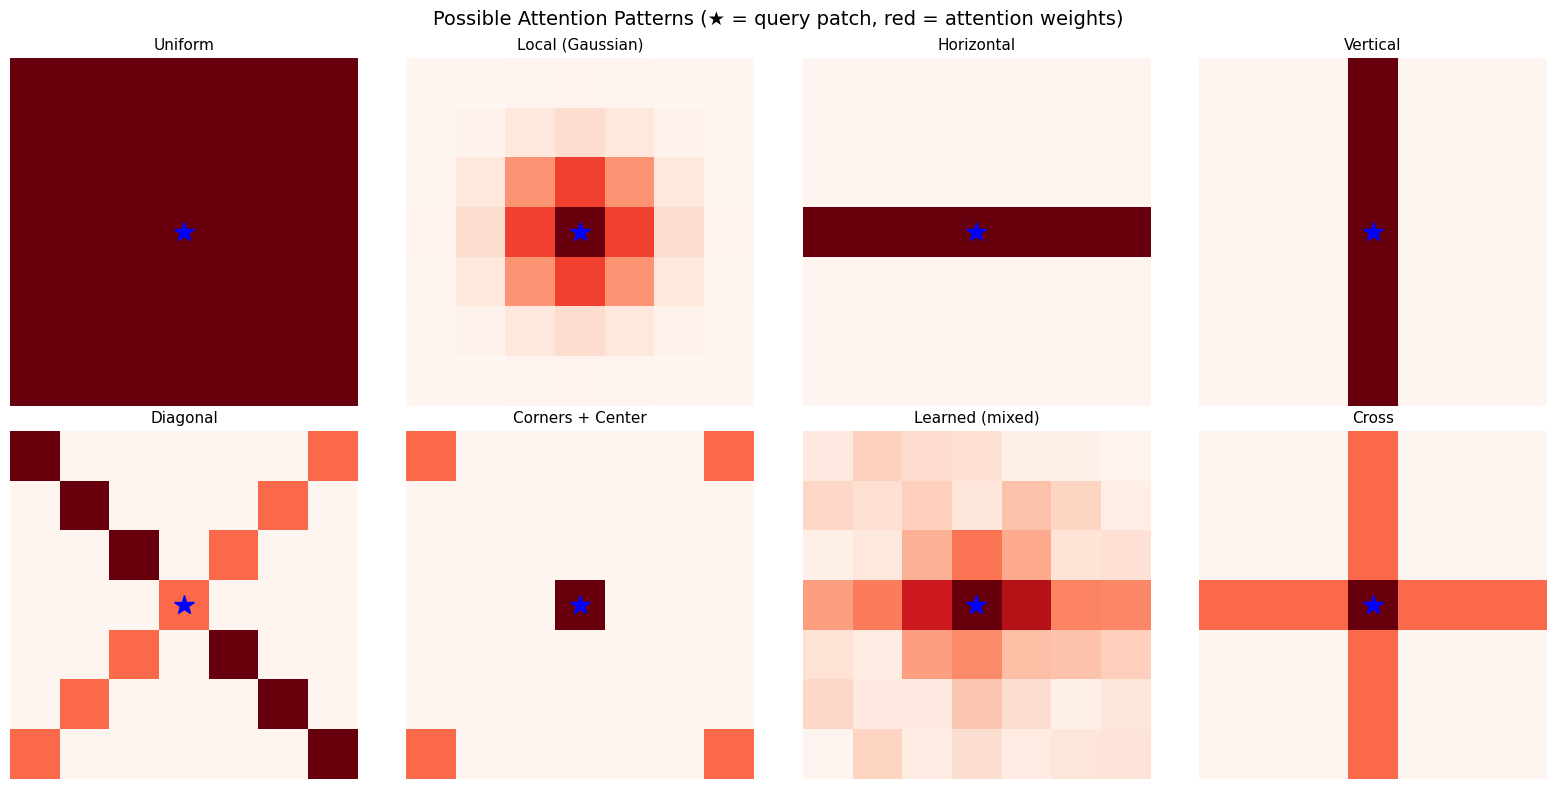


📊 Attention patterns the model might learn:
   • Early layers: Local patterns (like CNN kernels)
   • Middle layers: Structural patterns (horizontal, vertical strokes)
   • Late layers: Semantic patterns (attend to digit-specific regions)
   • The model learns which patterns are useful for the task!


In [6]:
def visualize_image_attention_patterns():
    """
    Show what attention patterns look like for image patches.
    """
    grid_size = 7
    N = grid_size ** 2  # 49 patches
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    query_pos = (3, 3)  # Center patch
    query_idx = query_pos[0] * grid_size + query_pos[1]
    
    patterns = [
        ('Uniform', np.ones((grid_size, grid_size)) / N),
        ('Local (Gaussian)', None),  # Will compute
        ('Horizontal', None),
        ('Vertical', None),
        ('Diagonal', None),
        ('Sparse', None),
        ('Learned (example)', None),
        ('Cross', None),
    ]
    
    # Compute patterns
    # Local Gaussian
    local = np.zeros((grid_size, grid_size))
    for i in range(grid_size):
        for j in range(grid_size):
            dist = np.sqrt((i - query_pos[0])**2 + (j - query_pos[1])**2)
            local[i, j] = np.exp(-dist**2 / 2)
    patterns[1] = ('Local (Gaussian)', local / local.sum())
    
    # Horizontal
    horiz = np.zeros((grid_size, grid_size))
    horiz[query_pos[0], :] = 1
    patterns[2] = ('Horizontal', horiz / horiz.sum())
    
    # Vertical
    vert = np.zeros((grid_size, grid_size))
    vert[:, query_pos[1]] = 1
    patterns[3] = ('Vertical', vert / vert.sum())
    
    # Diagonal
    diag = np.zeros((grid_size, grid_size))
    for i in range(grid_size):
        diag[i, i] = 1
        if grid_size - 1 - i >= 0:
            diag[i, grid_size - 1 - i] = 0.5
    patterns[4] = ('Diagonal', diag / diag.sum())
    
    # Sparse (corners + center)
    sparse = np.zeros((grid_size, grid_size))
    sparse[0, 0] = sparse[0, -1] = sparse[-1, 0] = sparse[-1, -1] = 1
    sparse[3, 3] = 2
    patterns[5] = ('Corners + Center', sparse / sparse.sum())
    
    # Learned-like (mixture)
    learned = local + 0.5 * horiz + 0.3 * np.random.rand(grid_size, grid_size)
    patterns[6] = ('Learned (mixed)', learned / learned.sum())
    
    # Cross
    cross = horiz + vert
    patterns[7] = ('Cross', cross / cross.sum())
    
    for idx, (name, pattern) in enumerate(patterns):
        ax = axes[idx // 4, idx % 4]
        im = ax.imshow(pattern, cmap='Reds', vmin=0)
        ax.plot(query_pos[1], query_pos[0], 'b*', markersize=15)
        ax.set_title(name, fontsize=11)
        ax.axis('off')
    
    plt.suptitle('Possible Attention Patterns (★ = query patch, red = attention weights)', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    print("\n📊 Attention patterns the model might learn:")
    print("   • Early layers: Local patterns (like CNN kernels)")
    print("   • Middle layers: Structural patterns (horizontal, vertical strokes)")
    print("   • Late layers: Semantic patterns (attend to digit-specific regions)")
    print("   • The model learns which patterns are useful for the task!")

visualize_image_attention_patterns()

## 4. Adaptive Layer Normalization (adaLN)

How do we tell the model what timestep we're at? In Phase 1, we simply added the timestep embedding to feature maps. DiT uses a more powerful approach: **Adaptive Layer Normalization**.

### Standard Layer Normalization

Layer Norm normalizes activations and applies learned affine transform:

$$\text{LayerNorm}(x) = \gamma \odot \frac{x - \mu}{\sigma} + \beta$$

where:
- $\mu, \sigma$ = mean and std of $x$ (computed per-sample)
- $\gamma, \beta$ = **learned** scale and shift parameters

### Adaptive Layer Norm (adaLN)

Instead of **learned** $\gamma, \beta$, we **predict** them from the timestep:

$$[\gamma, \beta] = \text{MLP}(\text{time\_embed}(t))$$
$$\text{adaLN}(x, t) = \gamma(t) \odot \frac{x - \mu}{\sigma} + \beta(t)$$

### Why This Is Powerful

| Approach | Conditioning Strength |
|----------|----------------------|
| **Additive** $(x + t_{emb})$ | Weak: just shifts activations |
| **Concatenation** $[x, t_{emb}]$ | Medium: separate channels |
| **adaLN** | Strong: scales AND shifts every activation |

adaLN modulates the **entire distribution** of activations, not just the mean. At each timestep, the model can:
- Amplify certain features ($\gamma > 1$)
- Suppress others ($\gamma \approx 0$)
- Shift the operating point ($\beta$)

### Timestep-Dependent Behavior

- **$t \approx 1$ (mostly noise)**: Model needs to find large-scale structure
- **$t \approx 0$ (mostly data)**: Model needs to refine fine details

adaLN lets the model behave **completely differently** at different timesteps!

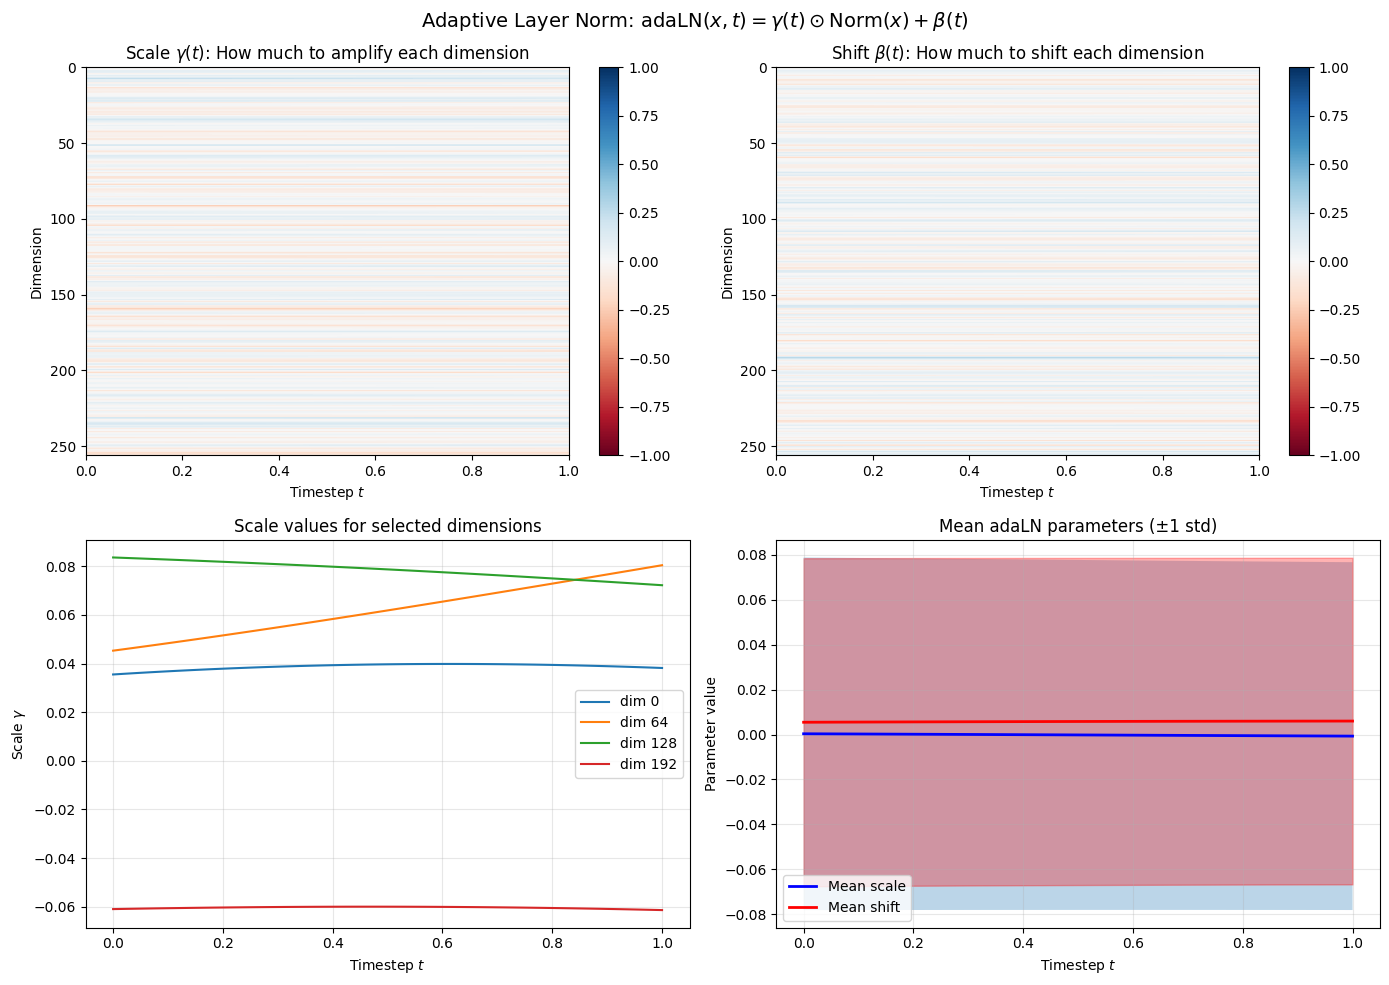


📊 adaLN Insights:
   • Each timestep produces different γ and β values
   • The model can amplify/suppress different features at different t
   • This is much more expressive than just adding timestep embeddings
   • Formula: output = γ(t) × LayerNorm(x) + β(t)


In [7]:
from from_noise_to_images.dit import TimestepEmbedding, AdaLN

def visualize_adaln_modulation():
    """
    Show how adaLN parameters vary with timestep.
    """
    embed_dim = 256
    cond_dim = embed_dim * 4
    
    time_embed = TimestepEmbedding(embed_dim, cond_dim)
    adaln = AdaLN(embed_dim, cond_dim)
    
    timesteps = torch.linspace(0, 1, 100)
    
    scales = []
    shifts = []
    
    with torch.no_grad():
        for t in timesteps:
            cond = time_embed(t.unsqueeze(0))
            params = adaln.proj(cond)
            scale, shift = params.chunk(2, dim=-1)
            scales.append(scale.squeeze().numpy())
            shifts.append(shift.squeeze().numpy())
    
    scales = np.array(scales)  # (100, 256)
    shifts = np.array(shifts)
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Scale heatmap
    im = axes[0, 0].imshow(scales.T, aspect='auto', cmap='RdBu', 
                           extent=[0, 1, embed_dim, 0], vmin=-1, vmax=1)
    axes[0, 0].set_xlabel('Timestep $t$')
    axes[0, 0].set_ylabel('Dimension')
    axes[0, 0].set_title('Scale $\\gamma(t)$: How much to amplify each dimension')
    plt.colorbar(im, ax=axes[0, 0])
    
    # Shift heatmap
    im = axes[0, 1].imshow(shifts.T, aspect='auto', cmap='RdBu',
                           extent=[0, 1, embed_dim, 0], vmin=-1, vmax=1)
    axes[0, 1].set_xlabel('Timestep $t$')
    axes[0, 1].set_ylabel('Dimension')
    axes[0, 1].set_title('Shift $\\beta(t)$: How much to shift each dimension')
    plt.colorbar(im, ax=axes[0, 1])
    
    # Selected dimensions
    for d in [0, 64, 128, 192]:
        axes[1, 0].plot(timesteps.numpy(), scales[:, d], label=f'dim {d}')
    axes[1, 0].set_xlabel('Timestep $t$')
    axes[1, 0].set_ylabel('Scale $\\gamma$')
    axes[1, 0].set_title('Scale values for selected dimensions')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Mean ± std
    mean_scale = scales.mean(axis=1)
    std_scale = scales.std(axis=1)
    mean_shift = shifts.mean(axis=1)
    std_shift = shifts.std(axis=1)
    
    axes[1, 1].plot(timesteps.numpy(), mean_scale, 'b-', label='Mean scale', linewidth=2)
    axes[1, 1].fill_between(timesteps.numpy(), mean_scale - std_scale, mean_scale + std_scale, alpha=0.3)
    axes[1, 1].plot(timesteps.numpy(), mean_shift, 'r-', label='Mean shift', linewidth=2)
    axes[1, 1].fill_between(timesteps.numpy(), mean_shift - std_shift, mean_shift + std_shift, alpha=0.3, color='red')
    axes[1, 1].set_xlabel('Timestep $t$')
    axes[1, 1].set_ylabel('Parameter value')
    axes[1, 1].set_title('Mean adaLN parameters (±1 std)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle('Adaptive Layer Norm: $\\text{adaLN}(x, t) = \\gamma(t) \\odot \\text{Norm}(x) + \\beta(t)$', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    print("\n📊 adaLN Insights:")
    print("   • Each timestep produces different γ and β values")
    print("   • The model can amplify/suppress different features at different t")
    print("   • This is much more expressive than just adding timestep embeddings")
    print(f"   • Formula: output = γ(t) × LayerNorm(x) + β(t)")

visualize_adaln_modulation()

## 5. The Complete DiT Architecture

Now let's put all the pieces together. The DiT architecture processes images through:

### Forward Pass

1. **Patchify**: $x \in \mathbb{R}^{H \times W \times C} \rightarrow p \in \mathbb{R}^{N \times (P^2 C)}$
2. **Embed**: $z = pE + \text{PE}_{2D} \in \mathbb{R}^{N \times D}$
3. **Condition**: $c = \text{MLP}(\text{sinusoidal}(t)) \in \mathbb{R}^{D_c}$
4. **Transform**: For $l = 1, \ldots, L$:
   - $z' = z + \text{Attention}(\text{adaLN}(z, c))$
   - $z = z' + \text{MLP}(\text{adaLN}(z', c))$
5. **Unpatchify**: $z \in \mathbb{R}^{N \times D} \rightarrow v \in \mathbb{R}^{H \times W \times C}$

### DiT Block Structure

```
Input z
   │
   ├───────────────────────────────────┐
   │                                   │ (residual)
   ▼                                   │
adaLN(z, c) ──► Self-Attention ──► + ──┤
                                       │
   ├───────────────────────────────────┘
   │                                   │ (residual)
   ▼                                   │
adaLN(z, c) ──► MLP ──────────────► + ──┘
   │
   ▼
Output z
```

### Computational Complexity

| Component | Complexity | For MNIST (N=49, D=256) |
|-----------|------------|-------------------------|
| Self-Attention | $O(N^2 D)$ | 49² × 256 ≈ 600K |
| MLP | $O(N D^2)$ | 49 × 256² ≈ 3.2M |
| Per Block | $O(N^2 D + N D^2)$ | ≈ 3.8M ops |
| Full Model (6 blocks) | | ≈ 23M ops |

In [8]:
from from_noise_to_images.dit import DiT

# Create DiT model
model = DiT(
    img_size=28,       # MNIST
    patch_size=4,      # 7×7 = 49 patches
    in_channels=1,     # Grayscale
    embed_dim=256,     # Embedding dimension D
    depth=6,           # Number of transformer blocks L
    num_heads=8,       # Attention heads H (256/8 = 32 dim per head)
    mlp_ratio=4.0,     # MLP hidden = 256 × 4 = 1024
).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"DiT Parameters: {num_params:,}")
print(f"\nArchitecture:")
print(f"   Patches: 7×7 = 49 (sequence length N)")
print(f"   Embedding: D = 256")
print(f"   Heads: H = 8 (head dim = 256/8 = 32)")
print(f"   MLP hidden: 256 × 4 = 1024")
print(f"   Blocks: L = 6")

# Test forward pass
test_x = torch.randn(4, 1, 28, 28, device=device)
test_t = torch.rand(4, device=device)

with torch.no_grad():
    test_out = model(test_x, test_t)

print(f"\nForward pass:")
print(f"   Input:  {test_x.shape}")
print(f"   Output: {test_out.shape}")
print(f"   ✓ Output shape matches input (predicts velocity field)")

DiT Parameters: 12,351,760

Architecture:
   Patches: 7×7 = 49 (sequence length N)
   Embedding: D = 256
   Heads: H = 8 (head dim = 256/8 = 32)
   MLP hidden: 256 × 4 = 1024
   Blocks: L = 6

Forward pass:
   Input:  torch.Size([4, 1, 28, 28])
   Output: torch.Size([4, 1, 28, 28])
   ✓ Output shape matches input (predicts velocity field)


In [9]:
# Trace through the model step by step
print("=" * 65)
print("TRACING DiT FORWARD PASS")
print("=" * 65)

x = torch.randn(1, 1, 28, 28, device=device)
t = torch.tensor([0.5], device=device)

print(f"\n1. INPUT")
print(f"   x ∈ ℝ^{tuple(x.shape)} (image)")
print(f"   t = {t.item():.1f} (timestep)")

with torch.no_grad():
    # Patchify
    patches = model.patch_embed(x)
    print(f"\n2. PATCHIFY")
    print(f"   Embed patches: {x.shape} → {patches.shape}")
    print(f"   (28×28 image → 49 patches × 256 dim)")
    
    # Position embed
    patches_pos = model.pos_embed(patches)
    print(f"\n3. POSITIONAL EMBEDDING")
    print(f"   Add PE: {patches_pos.shape}")
    print(f"   (Each patch knows its 2D position)")
    
    # Time embed
    cond = model.time_embed(t)
    print(f"\n4. TIMESTEP CONDITIONING")
    print(f"   t={t.item():.1f} → cond ∈ ℝ^{tuple(cond.shape)}")
    print(f"   (Sinusoidal encoding → MLP → conditioning vector)")
    
    # Transformer blocks
    print(f"\n5. TRANSFORMER BLOCKS (×{len(model.blocks)})")
    print(f"   Each block: adaLN → Attention → adaLN → MLP")
    print(f"   Residual connections preserve information")
    
    # Output
    output = model(x, t)
    print(f"\n6. OUTPUT")
    print(f"   Final norm → Linear → Unpatchify")
    print(f"   {patches.shape} → {output.shape}")
    print(f"   (Predicted velocity field)")

TRACING DiT FORWARD PASS

1. INPUT
   x ∈ ℝ^(1, 1, 28, 28) (image)
   t = 0.5 (timestep)

2. PATCHIFY
   Embed patches: torch.Size([1, 1, 28, 28]) → torch.Size([1, 49, 256])
   (28×28 image → 49 patches × 256 dim)

3. POSITIONAL EMBEDDING
   Add PE: torch.Size([1, 49, 256])
   (Each patch knows its 2D position)

4. TIMESTEP CONDITIONING
   t=0.5 → cond ∈ ℝ^(1, 1024)
   (Sinusoidal encoding → MLP → conditioning vector)

5. TRANSFORMER BLOCKS (×6)
   Each block: adaLN → Attention → adaLN → MLP
   Residual connections preserve information

6. OUTPUT
   Final norm → Linear → Unpatchify
   torch.Size([1, 49, 256]) → torch.Size([1, 1, 28, 28])
   (Predicted velocity field)


## 6. Training: Same Objective, Different Architecture

The beauty of flow matching is that the training objective is **architecture-agnostic**:

$$\mathcal{L} = \mathbb{E}_{x_0, x_1, t}\left[\|v_\theta(x_t, t) - (x_1 - x_0)\|^2\right]$$

We can swap the U-Net for DiT without changing anything else:
- Same forward process: $x_t = (1-t)x_0 + tx_1$
- Same velocity target: $v = x_1 - x_0$
- Same loss: MSE between predicted and true velocity
- Same sampling: Euler integration of the ODE

### Training Considerations for Transformers

| Aspect | CNN | DiT |
|--------|-----|-----|
| Parameters | ~1.8M | ~12.4M |
| Memory | Lower | Higher (attention matrices) |
| Speed | Faster per step | Slower per step |
| Convergence | Quick | Needs more epochs |
| Scaling | Diminishing returns | Predictable improvement |

In [10]:
from from_noise_to_images.train import Trainer

train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=0,
    drop_last=True
)

trainer = Trainer(
    model=model,
    dataloader=train_loader,
    lr=1e-4,
    weight_decay=0.01,
    device=device,
)

print("Training DiT with flow matching objective...")
print(f"Loss: L = ||v_θ(x_t, t) - (x_1 - x_0)||²")
print()

NUM_EPOCHS = 30
losses = trainer.train(num_epochs=NUM_EPOCHS)

Training DiT with flow matching objective...
Loss: L = ||v_θ(x_t, t) - (x_1 - x_0)||²

Training on cuda
Model parameters: 12,351,760


Epoch 1/30: 100%|████████████████| 468/468 [00:20<00:00, 22.93it/s, loss=0.3808]


Epoch 1: avg_loss = 0.8333


Epoch 2/30: 100%|████████████████| 468/468 [00:19<00:00, 23.48it/s, loss=0.2980]


Epoch 2: avg_loss = 0.3387


Epoch 3/30: 100%|████████████████| 468/468 [00:19<00:00, 23.48it/s, loss=0.2873]


Epoch 3: avg_loss = 0.3043


Epoch 4/30: 100%|████████████████| 468/468 [00:19<00:00, 23.45it/s, loss=0.2823]


Epoch 4: avg_loss = 0.2935


Epoch 5/30: 100%|████████████████| 468/468 [00:20<00:00, 23.39it/s, loss=0.2660]


Epoch 5: avg_loss = 0.2844


Epoch 6/30: 100%|████████████████| 468/468 [00:19<00:00, 23.48it/s, loss=0.2597]


Epoch 6: avg_loss = 0.2785


Epoch 7/30: 100%|████████████████| 468/468 [00:20<00:00, 23.36it/s, loss=0.2663]


Epoch 7: avg_loss = 0.2739


Epoch 8/30: 100%|████████████████| 468/468 [00:20<00:00, 23.37it/s, loss=0.2666]


Epoch 8: avg_loss = 0.2678


Epoch 9/30: 100%|████████████████| 468/468 [00:20<00:00, 23.27it/s, loss=0.2473]


Epoch 9: avg_loss = 0.2548


Epoch 10/30: 100%|███████████████| 468/468 [00:20<00:00, 23.31it/s, loss=0.2453]


Epoch 10: avg_loss = 0.2427


Epoch 11/30: 100%|███████████████| 468/468 [00:20<00:00, 23.34it/s, loss=0.2177]


Epoch 11: avg_loss = 0.2326


Epoch 12/30: 100%|███████████████| 468/468 [00:20<00:00, 23.27it/s, loss=0.2196]


Epoch 12: avg_loss = 0.2266


Epoch 13/30: 100%|███████████████| 468/468 [00:20<00:00, 23.29it/s, loss=0.2174]


Epoch 13: avg_loss = 0.2211


Epoch 14/30: 100%|███████████████| 468/468 [00:20<00:00, 23.36it/s, loss=0.2280]


Epoch 14: avg_loss = 0.2174


Epoch 15/30: 100%|███████████████| 468/468 [00:20<00:00, 23.28it/s, loss=0.2136]


Epoch 15: avg_loss = 0.2150


Epoch 16/30: 100%|███████████████| 468/468 [00:20<00:00, 23.24it/s, loss=0.2030]


Epoch 16: avg_loss = 0.2120


Epoch 17/30: 100%|███████████████| 468/468 [00:20<00:00, 23.17it/s, loss=0.1982]


Epoch 17: avg_loss = 0.2095


Epoch 18/30: 100%|███████████████| 468/468 [00:20<00:00, 23.21it/s, loss=0.2003]


Epoch 18: avg_loss = 0.2098


Epoch 19/30: 100%|███████████████| 468/468 [00:20<00:00, 23.15it/s, loss=0.2066]


Epoch 19: avg_loss = 0.2067


Epoch 20/30: 100%|███████████████| 468/468 [00:20<00:00, 23.29it/s, loss=0.2007]


Epoch 20: avg_loss = 0.2061


Epoch 21/30: 100%|███████████████| 468/468 [00:20<00:00, 23.18it/s, loss=0.2087]


Epoch 21: avg_loss = 0.2046


Epoch 22/30: 100%|███████████████| 468/468 [00:20<00:00, 23.18it/s, loss=0.1902]


Epoch 22: avg_loss = 0.2032


Epoch 23/30: 100%|███████████████| 468/468 [00:20<00:00, 23.14it/s, loss=0.2110]


Epoch 23: avg_loss = 0.2020


Epoch 24/30: 100%|███████████████| 468/468 [00:20<00:00, 23.16it/s, loss=0.2146]


Epoch 24: avg_loss = 0.2005


Epoch 25/30: 100%|███████████████| 468/468 [00:20<00:00, 23.17it/s, loss=0.1939]


Epoch 25: avg_loss = 0.2004


Epoch 26/30: 100%|███████████████| 468/468 [00:20<00:00, 23.12it/s, loss=0.1856]


Epoch 26: avg_loss = 0.1980


Epoch 27/30: 100%|███████████████| 468/468 [00:20<00:00, 23.14it/s, loss=0.2127]


Epoch 27: avg_loss = 0.1979


Epoch 28/30: 100%|███████████████| 468/468 [00:20<00:00, 23.09it/s, loss=0.2023]


Epoch 28: avg_loss = 0.1964


Epoch 29/30: 100%|███████████████| 468/468 [00:20<00:00, 23.11it/s, loss=0.1941]


Epoch 29: avg_loss = 0.1961


Epoch 30/30: 100%|███████████████| 468/468 [00:20<00:00, 23.11it/s, loss=0.1961]

Epoch 30: avg_loss = 0.1956


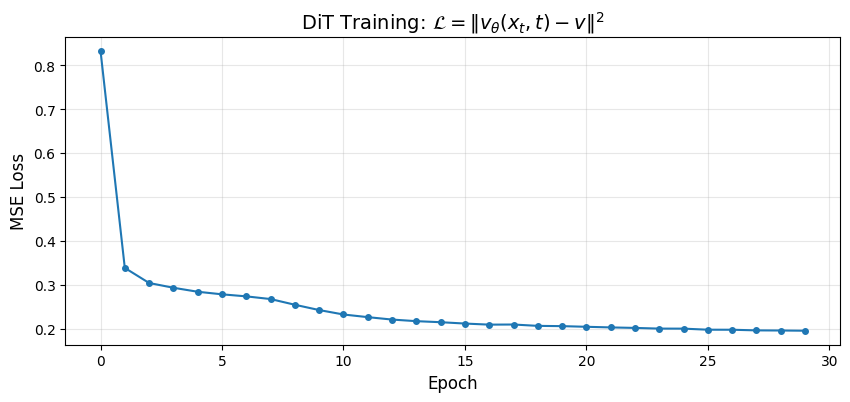

Final loss: 0.1956


In [11]:
plt.figure(figsize=(10, 4))
plt.plot(losses, marker='o', markersize=4)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.title('DiT Training: $\\mathcal{L} = \\|v_\\theta(x_t, t) - v\\|^2$', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

print(f"Final loss: {losses[-1]:.4f}")

## 7. Generation: Sampling from the Learned Model

Generation uses the same ODE as Phase 1:

$$\frac{dx}{dt} = v_\theta(x, t)$$

Starting from $x_1 \sim \mathcal{N}(0, I)$ at $t=1$, integrate backward to $t=0$:

$$x_{t-\Delta t} = x_t - \Delta t \cdot v_\theta(x_t, t)$$

The DiT's global attention should produce more coherent samples than the CNN's local processing.

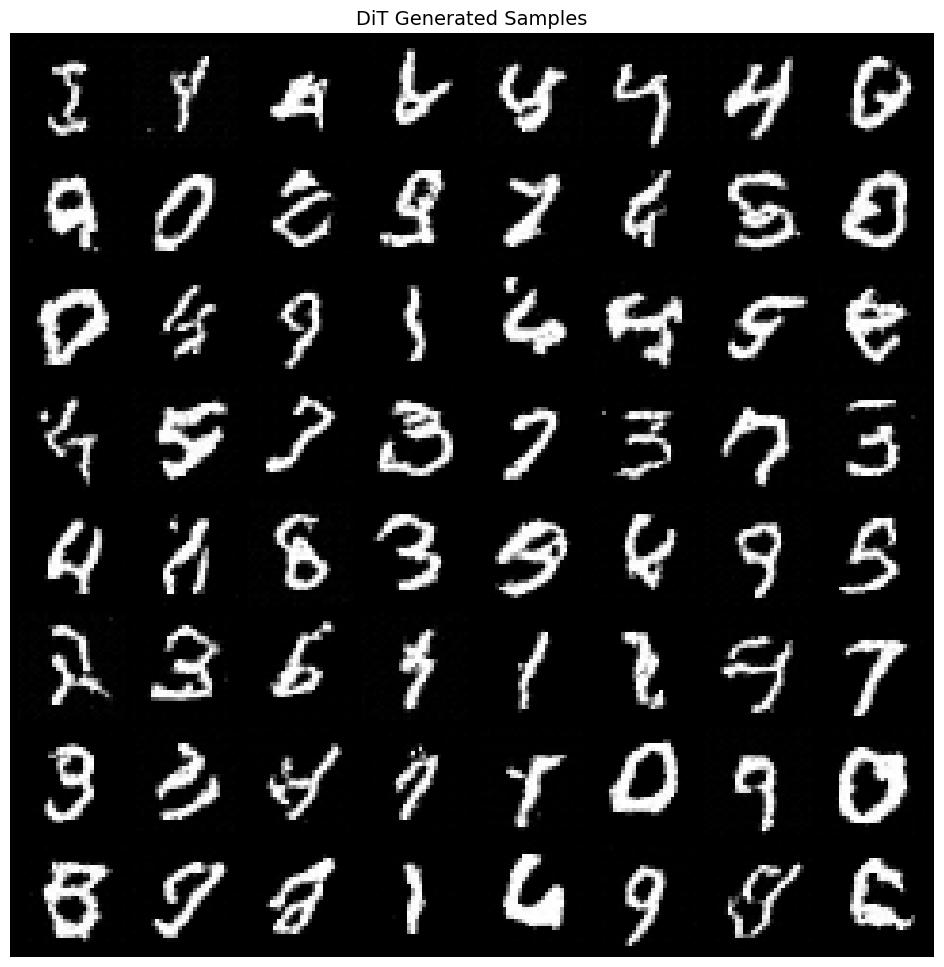

In [12]:
from from_noise_to_images.sampling import sample

def show_images(images, nrow=8, title=""):
    images = (images + 1) / 2
    images = images.clamp(0, 1)
    grid = torchvision.utils.make_grid(images, nrow=nrow, padding=2)
    plt.figure(figsize=(12, 12 * grid.shape[1] / grid.shape[2]))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap='gray')
    plt.axis('off')
    if title:
        plt.title(title, fontsize=14)
    plt.show()

model.eval()
with torch.no_grad():
    generated, trajectory = sample(
        model=model,
        num_samples=64,
        image_shape=(1, 28, 28),
        num_steps=50,
        device=device,
        return_trajectory=True,
    )

show_images(generated, nrow=8, title="DiT Generated Samples")

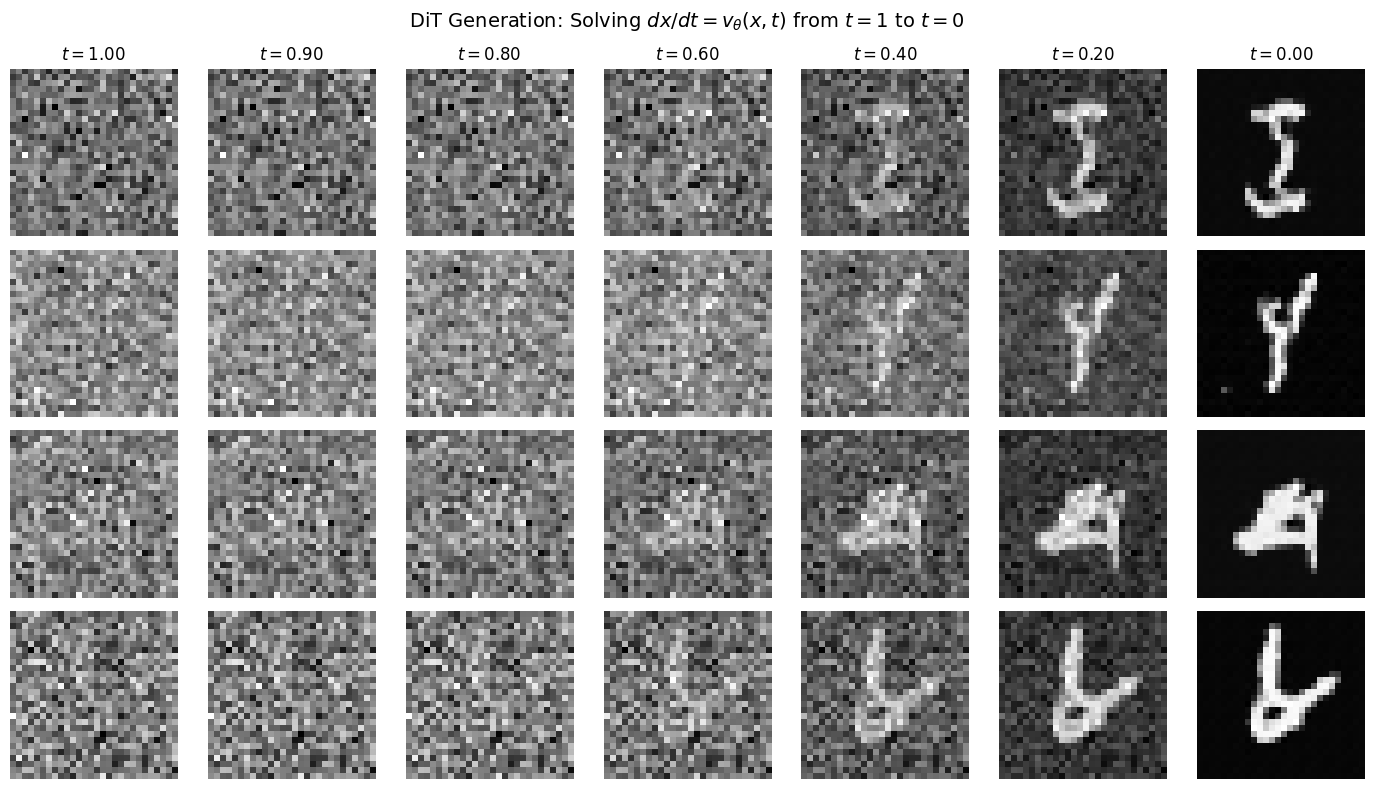

In [13]:
# Visualize generation process
num_to_show = 4
steps_to_show = [0, 5, 10, 20, 30, 40, 50]

fig, axes = plt.subplots(num_to_show, len(steps_to_show), figsize=(14, 8))

for row in range(num_to_show):
    for col, step_idx in enumerate(steps_to_show):
        img = (trajectory[step_idx][row, 0] + 1) / 2
        axes[row, col].imshow(img.cpu().numpy(), cmap='gray')
        axes[row, col].axis('off')
        if row == 0:
            t_val = 1.0 - step_idx / 50
            axes[row, col].set_title(f'$t={t_val:.2f}$')

plt.suptitle('DiT Generation: Solving $dx/dt = v_\\theta(x,t)$ from $t=1$ to $t=0$', fontsize=14)
plt.tight_layout()
plt.show()

## 8. CNN vs DiT Comparison

Let's directly compare the two architectures:

| Architecture | Parameters | Receptive Field | Conditioning |
|--------------|------------|-----------------|---------------|
| **U-Net (CNN)** | ~1.8M | Local → Global (via depth) | Additive |
| **DiT** | ~12.4M | Global (from layer 1) | adaLN (multiplicative) |

Loading CNN from phase1_model.pt...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.015714288..1.0197408].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.048832595..1.0588233].


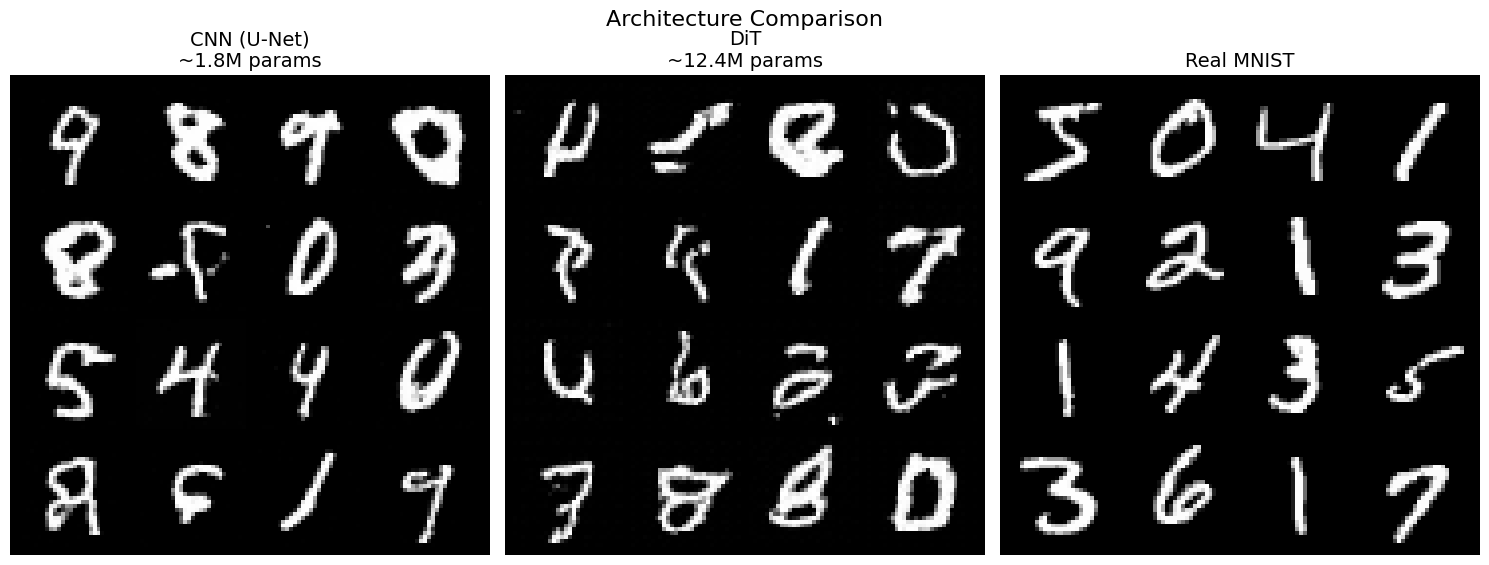

In [14]:
import os
from from_noise_to_images.models import SimpleUNet

# Load or train CNN
cnn_model = SimpleUNet(in_channels=1, model_channels=64, time_emb_dim=128).to(device)

if os.path.exists("phase1_model.pt"):
    print("Loading CNN from phase1_model.pt...")
    checkpoint = torch.load("phase1_model.pt", map_location=device)
    cnn_model.load_state_dict(checkpoint["model_state_dict"])
else:
    print("Training CNN for comparison...")
    cnn_trainer = Trainer(model=cnn_model, dataloader=train_loader, lr=1e-4, device=device)
    cnn_trainer.train(num_epochs=NUM_EPOCHS)

# Generate from both
model.eval()
cnn_model.eval()

with torch.no_grad():
    dit_samples = sample(model, 16, (1, 28, 28), 50, device)
    cnn_samples = sample(cnn_model, 16, (1, 28, 28), 50, device)

real_samples = torch.stack([train_dataset[i][0] for i in range(16)])

# Compare
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

for ax, samples, title in [
    (axes[0], cnn_samples, 'CNN (U-Net)\n~1.8M params'),
    (axes[1], dit_samples, 'DiT\n~12.4M params'),
    (axes[2], real_samples, 'Real MNIST'),
]:
    grid = torchvision.utils.make_grid((samples + 1) / 2, nrow=4, padding=2)
    ax.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap='gray')
    ax.set_title(title, fontsize=14)
    ax.axis('off')

plt.suptitle('Architecture Comparison', fontsize=16)
plt.tight_layout()
plt.show()

## Summary: Key Concepts

### What We Built

A Diffusion Transformer that processes images through:

1. **Patchification**: $x \in \mathbb{R}^{28 \times 28} \rightarrow z \in \mathbb{R}^{49 \times 256}$
2. **Positional Embeddings**: 2D sinusoidal encoding for spatial structure
3. **Self-Attention**: $\text{Attention}(Q,K,V) = \text{softmax}(QK^T/\sqrt{d})V$
4. **adaLN**: $\text{adaLN}(x,t) = \gamma(t) \cdot \text{Norm}(x) + \beta(t)$

### Mathematical Foundations

| Concept | Formula | Purpose |
|---------|---------|--------|
| Patchify | $z = xE + PE$ | Image → sequence |
| Attention | $\text{softmax}(QK^T/\sqrt{d})V$ | Global interactions |
| adaLN | $\gamma(t) \odot \text{Norm}(x) + \beta(t)$ | Timestep conditioning |
| Training | $\|v_\theta(x_t,t) - v\|^2$ | Learn velocity field |

### Why DiT Matters

- **Global from layer 1**: Every patch sees every other patch
- **Scaling laws**: Predictable improvement with more compute
- **Strong conditioning**: adaLN modulates all activations
- **Architecture simplicity**: Stack identical blocks

## Next: Phase 3

Add **class conditioning** to control generation:
- Class embeddings combined with timestep
- Classifier-Free Guidance (CFG)
- "Generate a 7" → produces a 7!

In [15]:
# Save model
trainer.save_checkpoint("phase2_dit.pt")